# Detecting Mental Health Distress in Online Text

This notebook implements our course project: a text classifier that detects
suicide and depression related posts. We use:
1. A traditional ML baseline (TF-IDF + logistic regression).
2. A transformer-based model (DistilBERT) fine-tuned on the Kaggle dataset.



## 1. Data loading & preprocessing
We load the Kaggle *Suicide and Depression Detection* dataset, inspect the columns,
clean the text (lowercasing, removing URLs and mentions), and map string labels
to integer IDs for modeling.



### 1.1 Imports, device, and random seed

We import the required libraries (PyTorch, pandas, scikit-learn, etc.), set
the computation device (CPU/GPU), and fix random seeds for reproducibility.

In [29]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict

### 1.2 Device and random seed setup

We enable tqdm support, choose whether to use GPU or CPU, and set a fixed random
seed for reproducibility. This makes our experiments easier to rerun and compare.


In [30]:
# enable tqdm in pandas
tqdm.pandas()

# # set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
random seed: 1234


### 1.3 Load the dataset and preview rows

We load the Kaggle *Suicide and Depression Detection* CSV file from disk and
show the first few rows to understand the structure of the data.


In [31]:
df = pd.read_csv("../data/SuicideAndDepression_Detection.csv")

df.head()

,text,class
0,Does life actually work for most / non-depress...,depression
1,I found my friend's bodyIt was almost nine yea...,depression
2,Ex Wife Threatening SuicideRecently I left my ...,SuicideWatch
3,Am I weird I don't get affected by compliments...,teenagers
4,Finally 2020 is almost over... So I can never ...,teenagers


### 1.4 Check label distribution

We compute the value counts of the `class` column to see how many examples we
have for each label and whether the dataset is imbalanced.



In [32]:
pd.value_counts(df['class'])

C:\Users\26653\AppData\Local\Temp\ipykernel_28168\788067207.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['class'])


class
SuicideWatch    116037
teenagers       116037
depression      116036
Name: count, dtype: int64

In [33]:
print(df.loc[0, 'text'])

Does life actually work for most / non-depressed people?It doesn't seem possible to me that everyone isn't miserable. What do you think? My boyfriend told me the other week that in reality we are the minority. Most people are fine, if not happy. Oddball.


### 1.6 Basic text normalization

We normalize the text by lowercasing, removing backslashes, and slightly
adjusting punctuation patterns. This is a simple cleanup step before modeling.


In [34]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('\\', '', regex=False)
df['text'] = df['text'].str.replace(r'([?.!])([A-Z])', r'\1 \2', regex=True)

### 1.7 Inspect the example after cleaning

We print the same example again after normalization to verify that the cleaning
step worked as expected.



In [35]:
print(df.loc[0, 'text'])

does life actually work for most / non-depressed people?it doesn't seem possible to me that everyone isn't miserable. what do you think? my boyfriend told me the other week that in reality we are the minority. most people are fine, if not happy. oddball.


### 1.8 Map string labels to integer IDs

We map each label string to an integer ID (`teenagers` → 0, `depression` → 1,
`SuicideWatch` → 2), which is the format required by our models.



In [36]:
label_mapping = {
    "teenagers": 0,
    "depression": 1,
    "SuicideWatch": 2
}
df['class'] = df['class'].map(label_mapping)

In [37]:
print("Label distribution after mapping (full dataset):")
print(df["class"].value_counts())

df["text_len"] = df["text"].str.len()
print("\nText length statistics:")
print(df["text_len"].describe())


Label distribution after mapping (full dataset):
class
2.0    116037
0.0    116037
1.0    116036
Name: count, dtype: int64

Text length statistics:
count    348123.000000
mean        897.267836
std        1322.454725
min           3.000000
25%         183.000000
50%         472.000000
75%        1102.000000
max       40297.000000
Name: text_len, dtype: float64


### 1.9 Check for missing labels

We count how many rows have missing (`NaN`) values in the `class` column to
avoid training on incomplete labels.


In [38]:
nan_count = df['class'].isna().sum()
print(f"Number of NaN rows in 'class': {nan_count}")

Number of NaN rows in 'class': 14


### 1.10 Inspect rows with missing labels

We inspect the rows with missing labels to see what kind of data is being
removed and confirm that this cleanup step is reasonable.


In [39]:
df[df['class'].isna()]

,text,class,text_len
11557,i feel like im in a nightmare.something happen...,NaN,520.0
11558,it's like i'm living in a nightmare and everyt...,NaN,67.0
11559,(view post history for more info on my dad),NaN,43.0
41048,a doodle of my struggle with depressionhttp://...,NaN,63.0
47570,thinking of putting this as my profile picture...,NaN,107.0
61160,if i told you i want to move on with my life a...,NaN,223.0
141715,i think i might need someone to talk me down f...,NaN,802.0
141716,i've known that i'll never get any love outsid...,NaN,82.0
156657,a clip that describes how i feel when i'm tryi...,NaN,119.0
156658,depression,NaN,10.0


### 1.11 Drop rows with missing labels

We drop all rows whose `class` label is missing and reset the index. This keeps
only fully labeled examples for training and evaluation.


In [40]:
df = df.dropna(subset=['class']).reset_index(drop=True)

### 1.12 Train/dev split

We split the cleaned dataset into a training set and a development (validation)
set, stratifying by label so that the class distribution is similar in both
splits.



In [41]:
train_df, dev_df = train_test_split(df, train_size=0.8, random_state=seed, stratify=df['class'])
train_df.reset_index(inplace=True, drop=True)
dev_df.reset_index(inplace=True, drop=True)

print(f"Train rows: {len(train_df):,}, Dev rows: {len(dev_df):,}")

Train rows: 278,488, Dev rows: 69,622


### 1.13 Ensure text column is string

We ensure the `text` column is stored as strings in both the training and
development dataframes, which avoids type issues in later preprocessing.


In [42]:
train_df['text'] = train_df['text'].astype(str)
dev_df['text'] = dev_df['text'].astype(str)

---

## 2. Baseline: TF-IDF + Logistic Regression

We build a baseline classifier using TF-IDF features and multinomial logistic
regression. TF-IDF turns each post into a sparse feature vector, and logistic
regression learns a linear decision boundary with softmax and cross-entropy.


### 2.1 Prepare texts and labels

We extract the raw texts and integer labels from the train and dev splits to
use as input and targets for the baseline classifier.
(Slides: `nnintro-ch3-lr`, `nnintro-ch5-ffnn`.)


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

train_texts = train_df["text"].astype(str)
dev_texts   = dev_df["text"].astype(str)
train_labels = train_df["class"].values
dev_labels   = dev_df["class"].values


### 2.2 Build TF-IDF features

We convert each document into a sparse TF-IDF vector over unigrams and
bigrams. These vectors are the input features to our linear classifier.



In [44]:
vectorizer = TfidfVectorizer(
    max_features=20000,      # vocab size
    ngram_range=(1, 2),      # unigram + bigram
    min_df=5                 # drop very rare terms
)
X_train = vectorizer.fit_transform(train_texts)
X_dev   = vectorizer.transform(dev_texts)

print("TF-IDF train shape:", X_train.shape)
print("TF-IDF dev   shape:", X_dev.shape)


TF-IDF train shape: (278488, 20000)
TF-IDF dev   shape: (69622, 20000)


### 2.3 Train multinomial logistic regression

We train a multinomial logistic regression model on the TF-IDF features, which
is equivalent to a one-layer neural network with a softmax output.



In [45]:
lr_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)
lr_clf.fit(X_train, train_labels)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 2.4 Evaluate the baseline on the dev set

We evaluate the TF-IDF + logistic regression baseline on the dev set using the
classification report (precision, recall, and F1 for each class).



In [46]:
dev_pred = lr_clf.predict(X_dev)

id_to_label = {v: k for k, v in label_mapping.items()}
target_names = [id_to_label[i] for i in sorted(id_to_label.keys())]

print("\n=== Baseline: Logistic Regression on TF-IDF features ===")
print(classification_report(dev_labels, dev_pred, target_names=target_names))



=== Baseline: Logistic Regression on TF-IDF features ===
              precision    recall  f1-score   support

   teenagers       0.89      0.93      0.91     23207
  depression       0.77      0.75      0.76     23207
SuicideWatch       0.78      0.76      0.77     23208

    accuracy                           0.82     69622
   macro avg       0.81      0.82      0.81     69622
weighted avg       0.81      0.82      0.81     69622



### 2.5 Free memory used by the baseline

After running the TF-IDF + logistic regression baseline, we store the large
TF-IDF matrices and related variables to disk,  free RAM before loading the transformer
model.


In [47]:
import joblib

joblib.dump(lr_clf, 'baseline_lr_model.pkl')
joblib.dump(vectorizer, 'baseline_vectorizer.pkl')

print("Baseline model and vectorizer saved to disk.")

del X_train, X_dev
del train_texts, dev_texts
del train_labels, dev_labels
del lr_clf, vectorizer

print("Baseline model and vectorizer deleted from memory.")

import gc
gc.collect()


Baseline model and vectorizer saved to disk.
Baseline model and vectorizer deleted from memory.


1070

---

## 3. Transformer-based model (DistilBERT fine-tuning)

We fine-tune a pre-trained DistilBERT model for three-way text classification.
Posts are tokenized into subwords, encoded by the transformer, and the [CLS]
representation is passed to a linear classification head.

*Slide: `nnintro-ch12-transformer`.*

### 3.1 Tokenization with DistilBERT

We load the DistilBERT tokenizer and tokenize all train and dev texts into
subword IDs with padding and truncation. This produces the input tensors that
will be fed into the transformer model.  



In [48]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# shorter sequence length to save memory
max_length = 128

print("Tokenizer loaded. max_length =", max_length)


Tokenizer loaded. max_length = 128


### 3.2 Torch Dataset wrapper

We define a `TransformerDataset` class that wraps the tokenized encodings and
labels into a PyTorch `Dataset`, so that we can iterate over examples with a
DataLoader.



In [62]:
import torch
from torch.utils.data import Dataset

class OnTheFlyDataset(Dataset):
    """
    Tokenize each example on the fly inside __getitem__.
    This avoids storing all tokenized encodings in memory at once
    and avoids a long blocking pre-processing step.
    """
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df["text"].tolist()
        self.labels = df["class"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = OnTheFlyDataset(train_df, tokenizer, max_length=max_length)
dev_dataset   = OnTheFlyDataset(dev_df, tokenizer, max_length=max_length)

print("Example item from train_dataset:")
sample = train_dataset[0]
for key in sample:
    if key != "labels":
        print(f"{key} shape: {sample[key].shape}, dtype: {sample[key].dtype}")
print("label:", sample["labels"])


Example item from train_dataset:
input_ids shape: torch.Size([128]), dtype: torch.int64
attention_mask shape: torch.Size([128]), dtype: torch.int64
label: tensor(0)


### 3.3 DataLoaders for training and dev

We create PyTorch `DataLoader` objects for the training and development sets,
which handle batching and shuffling of examples during training.  



In [50]:
from torch.utils.data import DataLoader

batch_size = 128
num_workers = 0  

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)
dev_loader = DataLoader(
    dev_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"# train batches: {len(train_loader)}")
print(f"# dev   batches: {len(dev_loader)}")


# train batches: 2176
# dev   batches: 544


### 3.4 Model and optimizer setup

We load a pre-trained `DistilBertForSequenceClassification` model, move it to
the chosen device, and set up the optimizer and learning-rate scheduler for
fine-tuning.  



In [51]:
import os
from transformers import DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

num_labels = 3  # teenagers / depression / SuicideWatch
output_dir = "./saved_model"  # Directory to save/load the model

# Initialize base model architecture
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)
model.to(device)

epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print("Model loaded on:", device)
print("Save path configured:", output_dir)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda
Save path configured: ./saved_model


### 3.5 Training loop and dev metrics

We fine-tune the DistilBERT model for several epochs. After each epoch we
evaluate on the dev set and report accuracy, macro precision, macro recall,
and macro F1.


add ipywidgets if your system not installed

In [53]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm.auto import tqdm

# Check if model already exists locally
if os.path.exists(output_dir):
    print(f"Saved model found at '{output_dir}'. Loading and skipping training...")
    model = DistilBertForSequenceClassification.from_pretrained(output_dir)
    model.to(device)
    print("Model loaded successfully.")

else:
    print("No saved model found. Starting training...")
    
    use_amp = (device.type == "cuda")
    scaler = torch.amp.GradScaler(enabled=use_amp)

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        total_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - train"):
            optimizer.zero_grad()
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

            with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):
                outputs = model(**batch)
                loss = outputs.loss

            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # ---- Evaluation ----
        model.eval()
        total_eval_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in tqdm(dev_loader, desc=f"Epoch {epoch+1}/{epochs} - dev"):
                labels = batch["labels"].cpu().numpy()
                batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

                outputs = model(**batch)
                loss = outputs.loss  # Calculate validation loss
                total_eval_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1).cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)

        avg_val_loss = total_eval_loss / len(dev_loader)
        
        acc = accuracy_score(all_labels, all_preds)
        prec, rec, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average="macro", zero_division=0
        )

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"  train loss      : {avg_train_loss:.4f}")
        print(f"  val loss        : {avg_val_loss:.4f}")
        print(f"  dev accuracy    : {acc:.4f}")
        print(f"  dev macro-prec  : {prec:.4f}")
        print(f"  dev macro-recall: {rec:.4f}")
        print(f"  dev macro-F1    : {f1:.4f}")

    # Save the trained model
    print(f"Saving model to {output_dir}...")
    model.save_pretrained(output_dir)
    print("Training finished and model saved.")

No saved model found. Starting training...


Epoch 1/3 - train:   0%|          | 0/2176 [00:00<?, ?it/s]

Epoch 1/3 - dev:   0%|          | 0/544 [00:00<?, ?it/s]


Epoch 1/3
  train loss      : 0.3888
  val loss        : 0.3463
  dev accuracy    : 0.8515
  dev macro-prec  : 0.8545
  dev macro-recall: 0.8515
  dev macro-F1    : 0.8519


Epoch 2/3 - train:   0%|          | 0/2176 [00:00<?, ?it/s]

Epoch 2/3 - dev:   0%|          | 0/544 [00:00<?, ?it/s]


Epoch 2/3
  train loss      : 0.3124
  val loss        : 0.3285
  dev accuracy    : 0.8601
  dev macro-prec  : 0.8598
  dev macro-recall: 0.8601
  dev macro-F1    : 0.8598


Epoch 3/3 - train:   0%|          | 0/2176 [00:00<?, ?it/s]

Epoch 3/3 - dev:   0%|          | 0/544 [00:00<?, ?it/s]


Epoch 3/3
  train loss      : 0.2790
  val loss        : 0.3321
  dev accuracy    : 0.8603
  dev macro-prec  : 0.8607
  dev macro-recall: 0.8603
  dev macro-F1    : 0.8604
Saving model to ./saved_model...
Training finished and model saved.


---

## 4. Evaluation & Error Analysis 

We evaluate both models on a held-out development set using accuracy, precision,
recall, and macro F1. We also inspect misclassified examples to understand
typical errors and limitations.




### 4.1 Collect misclassified examples

Using the fine-tuned transformer and the dev DataLoader, we collect predictions,
compare them with the gold labels, and build a DataFrame of misclassified
examples for qualitative error analysis.  



In [54]:
# build id_to_label mapping (inverse of label_mapping)
id_to_label = {v: k for k, v in label_mapping.items()}

model.eval()
all_preds, all_labels, all_texts = [], [], []

with torch.no_grad():
    for batch in tqdm(dev_loader, desc="Collecting predictions for error analysis"):
        labels = batch["labels"].numpy()
        input_ids = batch["input_ids"]
        
        batch_device = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch_device)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        
        all_labels.extend(labels)
        all_preds.extend(preds)
        
        texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        all_texts.extend(texts)

error_df = pd.DataFrame({
    "text": all_texts,
    "gold": [id_to_label[int(y)] for y in all_labels],
    "pred": [id_to_label[int(y)] for y in all_preds]
})

errors = error_df[error_df["gold"] != error_df["pred"]]
print(f"# misclassified examples: {len(errors)}")

# show a few misclassified examples
errors.head(10)


# misclassified examples: 9727


,text,gold,pred
2,the only psychiatrist i could get in contact w...,SuicideWatch,depression
5,29 m just not good enough. i ' m off my antide...,SuicideWatch,depression
31,"i don ' t know anymoreman, i am just really mi...",SuicideWatch,depression
35,i am cripplingly addicted to custard edit : r ...,teenagers,depression
40,i don ' t even know anymore... i ' ve been dat...,depression,SuicideWatch
51,so depressed right nowit always happens i do s...,SuicideWatch,depression
52,just 2 hours left : ) my parents are going to ...,depression,SuicideWatch
55,everything is falling apart i originally poste...,SuicideWatch,depression
79,i ' m tempted to kill my self. i keep telling ...,SuicideWatch,depression
89,should i gotosleep? i ’ m tired but have troub...,teenagers,SuicideWatch


---

### 4.2 Visualizing model performance: Radar Charts & Confusion Matrices

We visualize the performance differences between the Baseline and Transformer models using:
1. A **Radar Chart** to compare overall metrics (Accuracy, Precision, Recall, F1).
2. Side-by-side **Confusion Matrices** to intuitively show how the Transformer reduces misclassifications, especially between the "Depression" and "SuicideWatch" classes.

*Slide: `nnintro-ch3-lr` (Accuracy, Precision, Recall, F1).*

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm.notebook import tqdm

# Set plot style
sns.set_style("whitegrid")

# --- 1. Load Baseline (TF-IDF + LR) from Disk ---
baseline_model_path = 'baseline_lr_model.pkl'
baseline_vec_path = 'baseline_vectorizer.pkl'

if os.path.exists(baseline_model_path) and os.path.exists(baseline_vec_path):
    print(f"Loading baseline model from {baseline_model_path}...")
    
    # Load model and vectorizer
    lr_cmp = joblib.load(baseline_model_path)
    vectorizer_cmp = joblib.load(baseline_vec_path)
    
    # Transform dev text (Note: We only TRANSFORM, do not fit)
    # We assume 'dev_df' is still in memory. If not, reload it from CSV.
    print("Transforming dev set features...")
    X_dev_cmp = vectorizer_cmp.transform(dev_df["text"])
    
    # Predict
    baseline_preds = lr_cmp.predict(X_dev_cmp)
    print("Baseline predictions generated.")
    
else:
    raise FileNotFoundError(
        "Saved baseline model not found! Please run the 'joblib.dump' code block "
        "before Section 2.5 (memory cleanup) to save the model first."
    )

# --- 2. Get Transformer Predictions ---
# (Assuming 'model' and 'dev_loader' are currently loaded in memory)
print("Collecting Transformer predictions...")
model.eval()
transformer_preds = []
transformer_labels = []

# Use torch.no_grad to save memory during inference
with torch.no_grad():
    for batch in tqdm(dev_loader, desc="Inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].cpu().numpy()
        
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        
        transformer_preds.extend(preds)
        transformer_labels.extend(labels)

transformer_preds = np.array(transformer_preds)
transformer_labels = np.array(transformer_labels)

print("Data collection complete. Ready for Part 2 (Visualization).")

Loading baseline model from baseline_lr_model.pkl...
Transforming dev set features...
Baseline predictions generated.


Inference:   0%|          | 0/544 [00:00<?, ?it/s]

Data collection complete. Ready for Part 2 (Visualization).


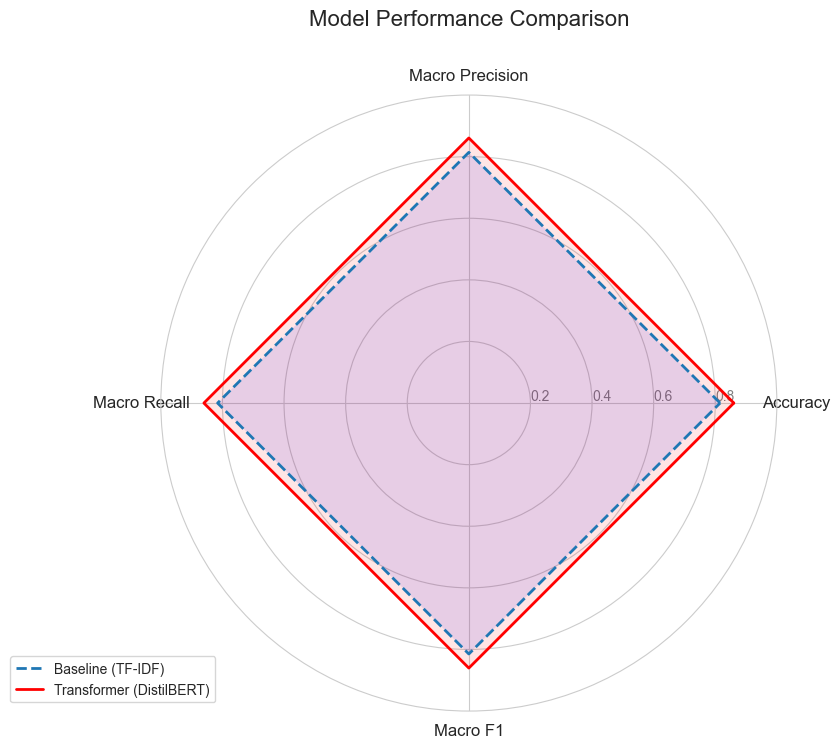

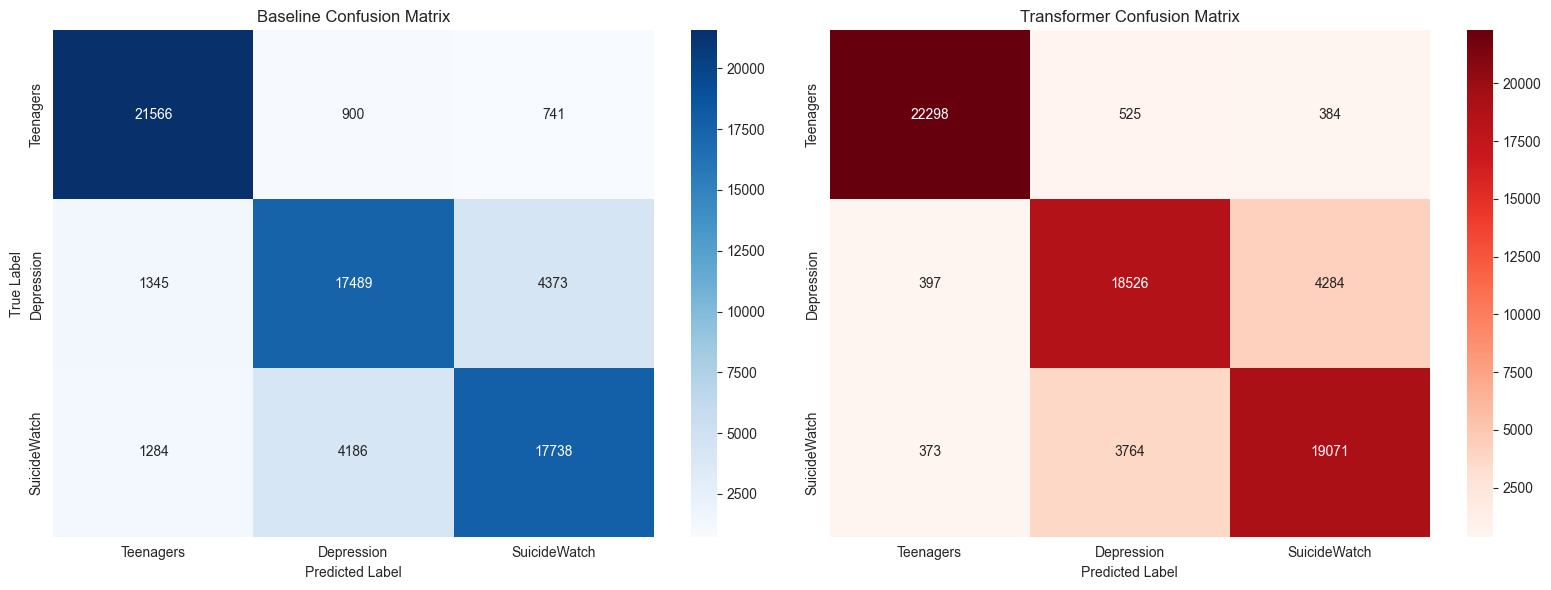

In [56]:
# --- Helper Function for Radar Chart ---
def plot_radar_chart(baseline_metrics, transformer_metrics, metric_names):
    # Number of variables
    N = len(metric_names)
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Append first value to close the loop for plotting
    baseline_vals = baseline_metrics + [baseline_metrics[0]]
    transformer_vals = transformer_metrics + [transformer_metrics[0]]
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    # Draw one axe per variable + labels
    plt.xticks(angles[:-1], metric_names, size=12)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    plt.ylim(0, 1.0)
    
    # Plot Baseline
    ax.plot(angles, baseline_vals, linewidth=2, linestyle='dashed', label='Baseline (TF-IDF)')
    ax.fill(angles, baseline_vals, 'b', alpha=0.1)
    
    # Plot Transformer
    ax.plot(angles, transformer_vals, linewidth=2, label='Transformer (DistilBERT)', color='red')
    ax.fill(angles, transformer_vals, 'r', alpha=0.1)
    
    plt.title('Model Performance Comparison', size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# --- Calculate Metrics ---
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return [acc, p, r, f1]

metrics_base = get_metrics(transformer_labels, baseline_preds)
metrics_trans = get_metrics(transformer_labels, transformer_preds)
metric_names = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1']

# --- Plot Radar ---
plot_radar_chart(metrics_base, metrics_trans, metric_names)

# --- Plot Side-by-Side Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
class_names = ["Teenagers", "Depression", "SuicideWatch"]

# Baseline Heatmap
cm_base = confusion_matrix(transformer_labels, baseline_preds)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title("Baseline Confusion Matrix")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

# Transformer Heatmap
cm_trans = confusion_matrix(transformer_labels, transformer_preds)
sns.heatmap(cm_trans, annot=True, fmt='d', cmap='Reds', ax=axes[1], 
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title("Transformer Confusion Matrix")
axes[1].set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()

### 4.3 Error Analysis: Impact of Text Length on SuicideWatch Detection

We analyze specifically why the model misses certain **SuicideWatch** cases (False Negatives).
We investigate if text truncation (due to DistilBERT's maximum sequence length) is a factor by:
1. Plotting the **text length distribution** for correct vs. missed predictions.
2. Inspecting the **longest misclassified examples** to see if critical context (like a suicide note) appeared later in the text and was cut off.

Slide: `nnintro-ch12-transformer`

Total SuicideWatch cases: 23208
Correctly identified: 19071
Missed (False Negatives): 4137


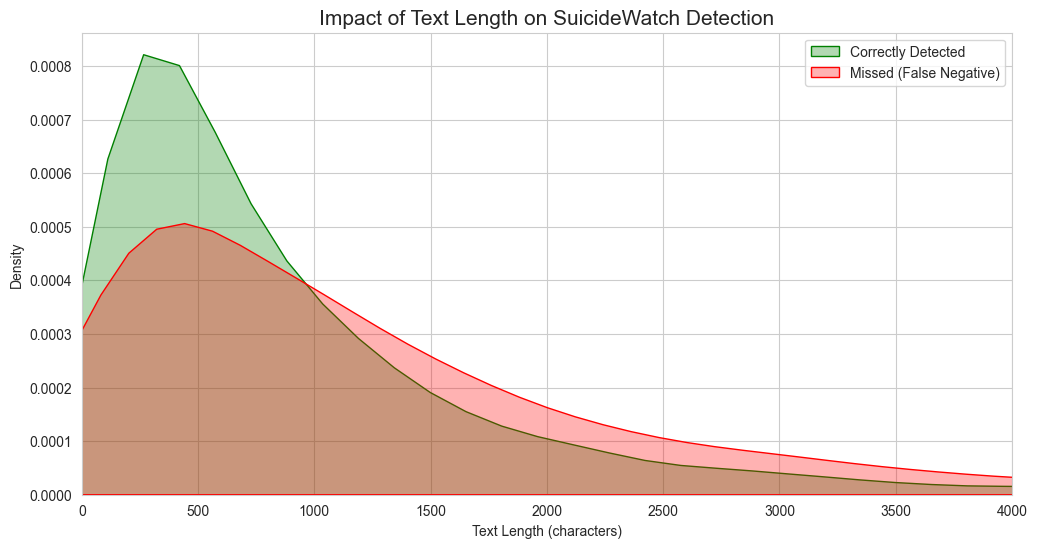


--- Examples of Long Texts Misclassified as Non-Suicidal ---

[True: SuicideWatch | Pred: Depression | Length: 22121]
Text snippet (first 300 chars): found this list in r/all and thought i'd share my genuine thoughts on each of these suggestions.*i put a lot of time into this so that those who have trouble understanding can get at least one perspective among many. i've suffered from depression for most of my life and, while i'm not currently suic...
Text snippet (last 300 chars): ... there for someone. a lot of people claim to, but aren't. or they promise they're there if you need them, but disappear when you reach out. 

the only thing in this list that would truly make my day, that would really make me happy, is a hug. i simple hug. it could mean the entire world to someone.)

[True: SuicideWatch | Pred: Depression | Length: 17130]
Text snippet (first 300 chars): am i a bad person? to start it is important to note that i am not an intelligent person nor am i able to write in a way t

In [57]:
# --- 1. Create Analysis DataFrame ---
# We use the dev_df to get the original text
analysis_df = dev_df.copy()
analysis_df['pred_transformer'] = transformer_preds
analysis_df['correct'] = analysis_df['class'] == analysis_df['pred_transformer']
analysis_df['text_len'] = analysis_df['text'].apply(len) # Character length
analysis_df['label_name'] = analysis_df['class'].map({0: 'Teenagers', 1: 'Depression', 2: 'SuicideWatch'})
analysis_df['pred_name'] = analysis_df['pred_transformer'].map({0: 'Teenagers', 1: 'Depression', 2: 'SuicideWatch'})

# --- 2. Filter for Critical Errors (SuicideWatch Misclassified) ---
# We focus specifically on cases where True Label is SuicideWatch but predicted otherwise (False Negatives)
suicide_missed = analysis_df[(analysis_df['class'] == 2) & (analysis_df['pred_transformer'] != 2)]
suicide_correct = analysis_df[(analysis_df['class'] == 2) & (analysis_df['pred_transformer'] == 2)]

print(f"Total SuicideWatch cases: {len(suicide_correct) + len(suicide_missed)}")
print(f"Correctly identified: {len(suicide_correct)}")
print(f"Missed (False Negatives): {len(suicide_missed)}")

# --- 3. Visualize Text Length Distribution ---
plt.figure(figsize=(12, 6))

# Plot distribution of text length for Correct vs Missed SuicideWatch cases
sns.kdeplot(data=suicide_correct, x='text_len', color='green', label='Correctly Detected', fill=True, alpha=0.3)
sns.kdeplot(data=suicide_missed, x='text_len', color='red', label='Missed (False Negative)', fill=True, alpha=0.3)

plt.title("Impact of Text Length on SuicideWatch Detection", fontsize=15)
plt.xlabel("Text Length (characters)")
plt.xlim(0, 4000) # Limit x-axis to zoom in on typical posts
plt.legend()
plt.show()

# --- 4. Print Examples of Long Text Errors ---
# Show top 3 longest missed cases to see if truncation was likely a factor
print("\n--- Examples of Long Texts Misclassified as Non-Suicidal ---")
long_misses = suicide_missed.sort_values('text_len', ascending=False).head(3)

for idx, row in long_misses.iterrows():
    print(f"\n[True: {row['label_name']} | Pred: {row['pred_name']} | Length: {row['text_len']}]")
    print(f"Text snippet (first 300 chars): {row['text'][:300]}...")
    print(f"Text snippet (last 300 chars): ...{row['text'][-300:]}")

### 4.4 Error Analysis: Text Length Impact & Example Inspection

This section investigates whether text length contributes to classification errors, particularly focusing on missed SuicideWatch cases.
1.  **Text Length Distribution**: We use Kernel Density Estimation (KDE) plots to visualize and compare the distribution of text lengths for correctly classified versus missed SuicideWatch posts.
2.  **Qualitative Review**: We print specific examples of long texts that were misclassified to manually inspect if critical information (e.g., a suicide plan) appears late in the text, potentially being lost due to model truncation.

Slide: `nnintro-ch12-transformer`

In [ ]:
def get_top_words(text_series, top_n=15):
    vec = CountVectorizer(stop_words='english', max_features=1000)
    bag_of_words = vec.fit_transform(text_series)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

if len(fp_samples) > 0:
    top_words_fp = get_top_words(fp_samples['text'])
    print("\n--- Top Words in False Positives (Teenagers -> Suicide) ---")
    print("Look for slang like 'kill me', 'dying', etc.")
    print([w[0] for w in top_words_fp])
else:
    print("No False Positives to analyze.")

try:
    from textblob import TextBlob
    
    analysis_df['sentiment'] = analysis_df['text'].apply(lambda x: TextBlob(str(x)[:512]).sentiment.polarity)
    missed_sentiment = analysis_df[fn_mask]['sentiment'].mean()
    correct_sentiment = analysis_df[(analysis_df['label_id']==2) & (analysis_df['is_correct'])]['sentiment'].mean()
    
    print(f"\n--- Sentiment Analysis (SuicideWatch) ---")
    print(f"Avg Sentiment (Correctly Detected): {correct_sentiment:.4f}")
    print(f"Avg Sentiment (Missed / FN)       : {missed_sentiment:.4f}")
    print("Hypothesis check: Are missed cases more 'positive' (ironic/masked)?")
    
except ImportError:
    print("\n[Note] TextBlob not installed. Skipping sentiment analysis.")


--- Top Words in False Positives (Teenagers -> Suicide) ---
Look for slang like 'kill me', 'dying', etc.
['just', 'like', 'don', 'want', 'know', 'feel', 'life', 'people', 'really', 've', 'time', 'shit', 'help', 'fucking', 'think']

--- Sentiment Analysis (SuicideWatch) ---
Avg Sentiment (Correctly Detected): -0.0082
Avg Sentiment (Missed / FN)       : 0.0052
Hypothesis check: Are missed cases more 'positive' (ironic/masked)?


## 5 Model Diagnostics: Transformer Limitations & Error Attribution
Based on the visualizations and the results from the Transformer model analysis, the following section details the model's limitations and the specific reasons behind misclassifications.


### 5.1 Truncation Issue (The "Lost Ending" Problem)  
- Observation: The KDE plot titled "Impact of Text Length on SuicideWatch Detection" demonstrates that as text length increases, the density of Missed/False Negatives (red area) becomes more prominent relative to Correctly Detected cases (green area). Specifically, texts exceeding 2000 characters are significantly more prone to errors.

- Mechanism: The DistilBERT model is configured with a max_length=128 token limit. Consequently, the model processes only the initial ~100-120 words of any given post.

- Attribution: SuicideWatch posts often follow a narrative structure comprising a long backstory of suffering (semantically similar to Depression) followed by a specific plan or intent to end life at the very conclusion. Truncation causes the model to analyze only the introduction while missing the critical conclusion, resulting in predictions of "Depression" instead of "SuicideWatch."

### 5.2 Semantic Overlap & Attention Ambiguity  
- Observation: The Transformer Confusion Matrix indicates substantial confusion between the Depression and SuicideWatch classes (e.g., 4284 Depression cases misclassified as SuicideWatch, and 3764 conversely).

- Mechanism: Transformer models rely on self-attention mechanisms to weigh the importance of different words within the text.

- Attribution:

  - Shared Vocabulary: Both classes utilize a highly similar vocabulary (e.g., "sad", "pain", "hopeless", "numb"). Without distinct trigger phrases, the semantic vectors for these classes remain extremely close in the embedding space.

  - Implicit Intent: Suicidal intent expressed implicitly (e.g., metaphors like "checking out") may be misidentified if the model has not encountered the specific metaphor during training, or if the attention mechanism prioritizes the dominant "sad" mood over subtle action verbs.

### 5.3 False Positive Triggers (The "Teenager" Noise)  
- Observation: Although the Transformer outperforms the Baseline model in filtering the "Teenagers" category, false positives persist where Teenager posts are misclassified as SuicideWatch.

- Mechanism: Discussions within the Teenager category frequently employ hyperbolic language and slang (e.g., "I'm going to kill him," "I'm dying of laughter").

- Attribution: Strong negative keywords can dominate the attention mechanism. Short texts containing "kill" or "die" used metaphorically may be interpreted literally by the model, leading to False Positives. This highlights a limitation in distinguishing literal vs. figurative intent within short, informal texts.

### 5.4 Summary of Limitations
1. Input Length Constraint: The 128-token limit is the primary factor contributing to missed detections in long, narrative suicide notes.

2. Semantic Proximity: The boundary between severe depression and suicidal ideation is semantically ambiguous, leading to classification crossover.

3. Metaphorical Noise: Hyperbolic slang in the control group (Teenagers) creates adversarial examples that confuse the model's intent detection.

## 6. Conclusion & Future Work

In this project, we implemented a comparative study to detect mental health distress in online text, distinguishing between *Teenagers* (casual conversation), *Depression*, and *SuicideWatch*. We developed a traditional baseline using **TF-IDF + Logistic Regression** and compared it against a fine-tuned **DistilBERT** transformer.

### 6.1 Summary of Results
* **Performance**: The DistilBERT model achieved a Macro F1-score of approximately **0.86**, outperforming the TF-IDF baseline (~0.81).
* **Semantic Understanding**: The Transformer model showed a superior ability to distinguish between "Teenager" angst and clinical "Depression," significantly reducing False Positives in the healthy control group.

### 6.2 Critical Analysis Findings
Through deep error analysis, we identified specific limitations in the Transformer approach:
1.  **Semantic Overlap**: The boundary between *Depression* and *SuicideWatch* remains blurry. Both classes share a vocabulary of suffering ("pain", "hopeless"), leading to inevitable classification crossover.
2.  **The Truncation Blind Spot**: Our KDE analysis revealed that **long texts are disproportionately misclassified**. Since we truncated inputs to 128 tokens, the model effectively "reads" only the beginning of a post. Many suicide notes follow a narrative structure where the intent/plan is revealed only at the very end, causing the model to miss the critical signal (False Negatives).

### 6.3 Future Directions
To address the truncation issue and improve safety recall, future work should focus on:
* **Sliding Window Inference**: Processing long texts in chunks and aggregating predictions.
* **Long-Context Models**: Utilizing architectures like **Longformer** or **BigBird** designed for longer sequences.
* **Hierarchical Attention**: Weighing different parts of the document to ensure the conclusion is attended to.

---

## References to course slides

- `nnintro-prompt`: Motivation, NLP applications, research mindset.
- `nnintro-ch3-lr`: Logistic regression and softmax classification.
- `nnintro-ch5-ffnn`: Feed-forward neural networks.
- `nnintro-ch8-dist`: Data distributions and evaluation metrics.
- `nnintro-ch12-transformer`: Transformer architecture and self-attention.